# Get boundary of Contiguous United States (CONUS) and administrative information

In [29]:
import helpers as h
import functools
import time
import logging, logging.handlers
import csv
import os
import psutil
import json
from datetime import datetime
import pandas as pd
import geopandas as gpd
from shapely import to_wkt
from shapely.wkt import dumps, loads
from shapely.geometry import Polygon, box, Point
from shapely.geometry.base import BaseGeometry
from shapely.ops import transform
import random
import uuid
import psycopg2
from psycopg2 import sql, extras
import geohash2 as geohash
import itertools
import numpy as np
import pyproj
import multiprocessing as mp
import os
import math
import matplotlib.pyplot as plt
import geopandas as gpd

In [30]:
tl = gpd.read_parquet('data/tl_2024_us_county.geo.parquet')

<Axes: >

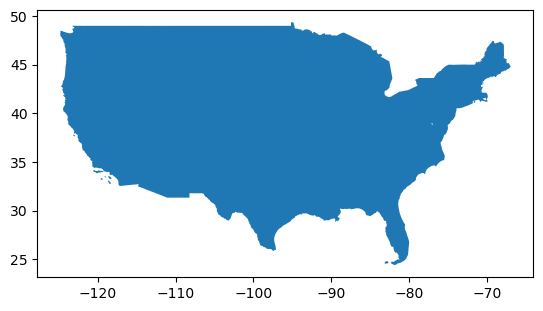

In [31]:
conus_fips = [
    '01', '04', '05', '06', '08', '09', '10', '12', '13', '16', '17', '18', '19',
    '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
    '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
    '49', '50', '51', '53', '54', '55', '56'
]

conus = tl[tl['STATEFP'].isin(conus_fips)]
conus_boundary = conus.dissolve()
conus_boundary.to_file('data/conus_boundary.parquet', driver='Parquet')
conus_boundary.plot()

<Axes: >

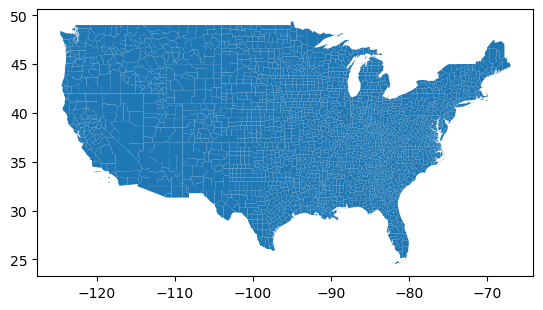

In [32]:
admin_boundaries = gpd.read_file("data/geoBoundaries-USA-ADM2.geojson")  # City, county, state
conus_boundary = conus_boundary.to_crs(epsg=4326)
admin_boundaries.to_crs(conus_boundary.crs)

conus_admin = gpd.overlay(admin_boundaries, conus_boundary, how='intersection')
conus_admin.to_parquet('data/conus_admin.parquet')
conus_admin.plot()

<Axes: >

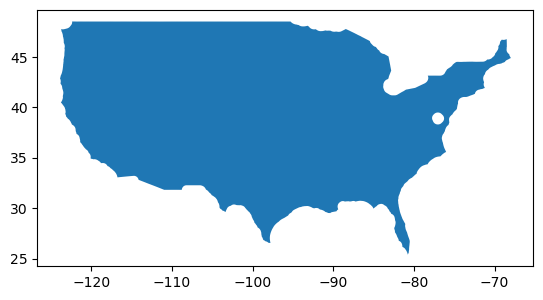

In [33]:
conus_buffer = conus_boundary.to_crs(epsg=5070) # albers equal good for U.S.
conus_buffer['geometry'] = conus_buffer.geometry.buffer(-55000) # 10km buffer
conus_buffer = conus_buffer.to_crs(epsg=4326)
conus_buffer.to_file('data/conus_buffer.parquet', driver='Parquet')
conus_buffer.plot()

Test out function:

In [34]:
# Run the function
gdf, _ = h.generate_random_polygons(n=10000, us_boundary=conus_buffer, admin_boundaries=conus_admin)
gdf.head()

Function `generate_random_polygons` executed in 8.1934 sec, CPU: 6.20%, Memory: 68.23MB


,geometry,id,geohash
1200,"POLYGON ((-81.09807 26.87128, -81.09807 26.929...",f78a45f2-cc9a-4fa8-bc6f-81e8165d7e5b,dhy353p4
5981,"POLYGON ((-81.46158 26.96102, -81.46158 26.988...",8279dd37-bcb6-49f5-9e4f-7b94699e248f,dhy16wwf
6151,"POLYGON ((-81.10502 26.97978, -81.10502 27.029...",8b640106-3970-4b17-8922-19733bc7bc9b,dhy3ekj6
1600,"POLYGON ((-80.84511 27.09518, -80.84511 27.168...",7e8404aa-a4f1-405f-b598-5e8eea078eed,dhyd27nr
2718,"POLYGON ((-80.93382 27.15122, -80.93382 27.166...",d9696332-6682-499d-8547-ee935afbaa77,dhy6w2jd


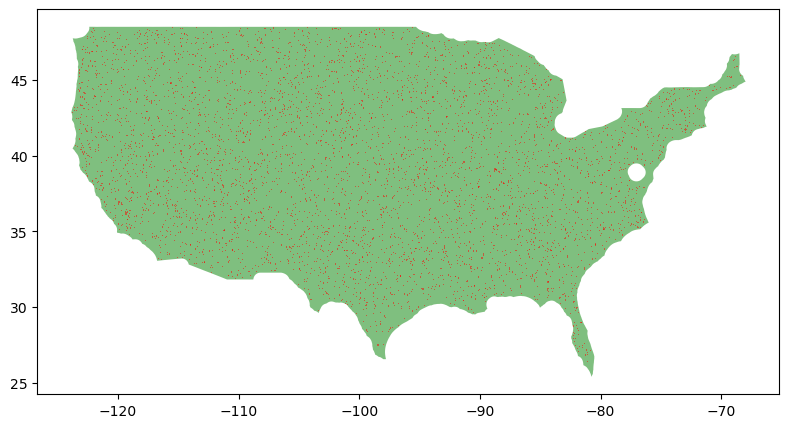

In [35]:
# plot the polygons
fig, ax = plt.subplots(figsize=(10, 5))
conus_buffer.plot(ax=ax, color="green", alpha=0.5)  # CONUS boundary
gdf.plot(ax=ax, color="red", alpha=0.5)  # Random polygons
plt.show()

The polygons are very small, so it's hard to see, but they're there!

Confirm area of the first polygon and the average area of the polygons:

In [36]:
area = gdf.to_crs(epsg=3857).loc[1, "geometry"].area
print(f"First polygon area: {area} square meters")

area = gdf.to_crs(epsg=3857).geometry.area
print(f'Mean polygon area:  {area.mean()} square meters')

side_length = math.sqrt(area.mean())
print(f'Mean polygon side length if they were squares: {side_length} meters')

First polygon area: 133502725.17363763 square meters
Mean polygon area:  48824516.98964763 square meters
Mean polygon side length if they were squares: 6987.454256712356 meters


These are large polygons, too large for individual buildings, but for our purposes this should work.

## Now, generate polygons for the project

In [57]:
def generate_random_polygons(n: int, 
                             us_boundary: gpd.GeoDataFrame = gpd.read_file('data/conus_buffer.parquet'), 
                             admin_boundaries: gpd.GeoDataFrame = gpd.read_file('data/conus_admin.parquet'), 
                            #  precision=7) -> gpd.GeoDataFrame:
                             precision=6) -> gpd.GeoDataFrame:
    """
    Generate n random polygons fully within the contiguous U.S. (CONUS).
    Ensures all polygons are clipped to the CONUS boundary.

    Params:
        n (int): number of polygons to be generated
        us_boundary: a GeoPandas GeoDataframe of the boundary of the US
        admin_boundaries: a GeoPandas GeoDataframe of the administrative information of the US

    Returns:
        gdf: a GeoPandas GeoDataframe of the polygon layer with administrative and geohash information.
    """
    if us_boundary is None or admin_boundaries is None:
        raise ValueError("Both U.S. boundary and administrative boundaries are required.")

    # Compute bounding box of CONUS
    minx, miny, maxx, maxy = us_boundary.total_bounds

    polygons = []
    ids = []

    while len(polygons) < n:
        # Generate random coordinates within the bounding box
        x1, y1 = random.uniform(minx, maxx), random.uniform(miny, maxy)
        x2, y2 = x1 + random.uniform(0.01, 0.1), y1 + random.uniform(0.01, 0.1)
        # x2, y2 = x1 + random.uniform(0.0001, 0.001), y1 + random.uniform(0.0001, 0.001)
        polygon = box(x1, y1, x2, y2)

        # Ensure the polygon is fully within the CONUS boundary
        if polygon.within(us_boundary.geometry.iloc[0]):  # Checks containment
            polygons.append(polygon)
            ids.append(str(uuid.uuid4()))

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
    gdf["id"] = ids

    # Clip to CONUS boundary (extra safeguard)
    gdf = gpd.clip(gdf, us_boundary)

    # Compute representative points for spatial join
    gdf["rep_point"] = gdf.geometry.representative_point()

    # Perform spatial join to get city, county, state
    gdf = gdf.sjoin(admin_boundaries, how="left", predicate="within")

    # Compute geohash for location
    gdf["geohash"] = gdf["rep_point"].apply(
        lambda geom: geohash.encode(geom.y, geom.x, precision) if geom else None
    )

    # Drop temporary columns
    gdf = gdf.drop(columns=["rep_point", "index_right"])

    # Drop other columns
    cols_to_keep = [
        'geometry', 
        'id',
        # 'shapeName', 
        # 'STATEFP', 
        # 'COUNTYFP', 
        # 'GEOID', 
        # 'NAME', 
        # 'NAMELSAD', 
        # 'area_fips', 
        'geohash']
    
    # save metadata
    meta_df = gdf[[
        'id',
        'shapeName', 
        'STATEFP', 
        'COUNTYFP', 
        'GEOID', 
        'NAME', 
        'NAMELSAD', 
        'area_fips']]

    # save gdf with dropped cols
    gdf = gdf[cols_to_keep]

    return gdf, meta_df

In [58]:
# prev_month_blobs, prev_meta = generate_random_polygons(n=5000) # 100000
# curr_month_blobs, curr_meta = generate_random_polygons(n=5000) # 100000

prev_month_blobs, prev_meta = generate_random_polygons(n=10000) # 100000
curr_month_blobs, curr_meta = generate_random_polygons(n=10000) # 100000

In [59]:
prev_month_blobs.head()

,geometry,id,geohash
1742,"POLYGON ((-98.15546 26.70653, -98.15546 26.781...",eb1f2cde-b3d8-4cc2-b329-b43a3de437d2,9uf0ps
7759,"POLYGON ((-98.05450 26.83720, -98.05450 26.907...",664f5837-4d2f-4eb2-a628-368b73472e43,9uf2bu
2505,"POLYGON ((-98.16010 26.87652, -98.16010 26.900...",a44635da-3b70-4560-b21c-4fd695b95cfe,9uf0yy
7393,"POLYGON ((-98.33358 26.90668, -98.33358 26.924...",c6cb932e-7bdb-472c-bef8-9e55fb6e7527,9uf14e
354,"POLYGON ((-98.16054 27.02437, -98.16054 27.043...",1e425d86-b288-465c-8f88-5569aae2edfd,9uf1yc


In [60]:
area = prev_month_blobs.to_crs(epsg=3857).loc[1, "geometry"].area
print(f"First polygon area: {area} square meters")

area = prev_month_blobs.to_crs(epsg=3857).geometry.area
print(f'Mean polygon area:  {area.mean()} square meters')

side_length = math.sqrt(area.mean())
print(f'Side length of a square polygon given mean area: {side_length} meters')

First polygon area: 17977248.354052894 square meters
Mean polygon area:  48719924.13159012 square meters
Side length of a square polygon given mean area: 6979.965911921785 meters


In [61]:
prev_meta.head()

,id,shapeName,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,area_fips
1742,eb1f2cde-b3d8-4cc2-b329-b43a3de437d2,Hidalgo,31,039,31039,Cuming,Cuming County,31039
7759,664f5837-4d2f-4eb2-a628-368b73472e43,Brooks,31,039,31039,Cuming,Cuming County,31039
2505,a44635da-3b70-4560-b21c-4fd695b95cfe,Brooks,31,039,31039,Cuming,Cuming County,31039
7393,c6cb932e-7bdb-472c-bef8-9e55fb6e7527,Brooks,31,039,31039,Cuming,Cuming County,31039
354,1e425d86-b288-465c-8f88-5569aae2edfd,Brooks,31,039,31039,Cuming,Cuming County,31039


In [62]:
prev_month_blobs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 10000 entries, 1742 to 6598
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  10000 non-null  geometry
 1   id        10000 non-null  object  
 2   geohash   10000 non-null  object  
dtypes: geometry(1), object(2)
memory usage: 570.5+ KB


Save to .parquet:

In [63]:
prev_month_blobs.to_file('data/prev_month_blobs_5k.parquet', driver='Parquet')
prev_meta.to_parquet('data/prev_meta_5k.parquet')
curr_month_blobs.to_file('data/curr_month_blobs_5k.parquet', driver='Parquet')
curr_meta.to_parquet('data/curr_meta_5k.parquet')

# prev_month_blobs.to_file('data/prev_month_blobs_10k.parquet', driver='Parquet')
# prev_meta.to_parquet('data/prev_meta_10k.parquet')
# curr_month_blobs.to_file('data/curr_month_blobs_10k.parquet', driver='Parquet')
# curr_meta.to_parquet('data/curr_meta_10k.parquet')

print('Done.')

Done.
